In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

data = pd.read_csv('AMZN.csv')

data

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000
...,...,...,...,...,...,...,...
6511,2023-03-30,101.550003,103.040001,101.010002,102.000000,102.000000,53633400
6512,2023-03-31,102.160004,103.489998,101.949997,103.290001,103.290001,56704300
6513,2023-04-03,102.300003,103.290001,101.430000,102.410004,102.410004,41135700
6514,2023-04-04,102.750000,104.199997,102.110001,103.949997,103.949997,48662500


In [61]:
data = data[['Date', 'Close']]
data

,Date,Close
0,1997-05-15,0.097917
1,1997-05-16,0.086458
2,1997-05-19,0.085417
3,1997-05-20,0.081771
4,1997-05-21,0.071354
...,...,...
6511,2023-03-30,102.000000
6512,2023-03-31,103.290001
6513,2023-04-03,102.410004
6514,2023-04-04,103.949997


In [62]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

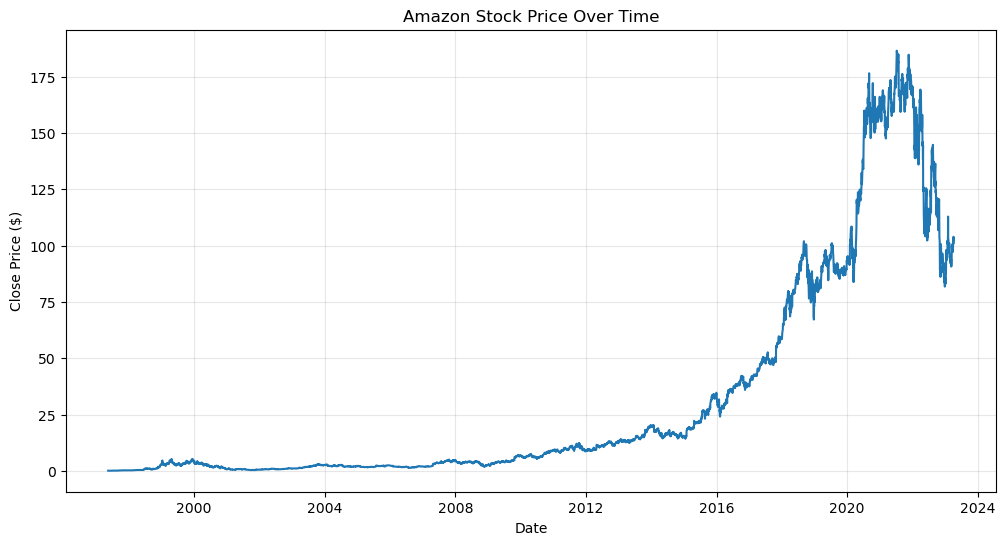

In [63]:
# Fix the copy warning by creating a proper copy
data = data.copy()
data['Date'] = pd.to_datetime(data['Date'])

plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Close'])
plt.title('Amazon Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.grid(True, alpha=0.3)
plt.show()

In [64]:
from copy import deepcopy as dc
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

def prepare_dataframe_for_lstm(df, n_steps):
    """
    Prepare DataFrame for LSTM by creating lagged features.
    
    Args:
        df: DataFrame with Date and Close columns
        n_steps: Number of historical steps to use as features
    
    Returns:
        DataFrame with shifted features
    """
    df = dc(df)
    
    # Set index without inplace to avoid chained assignment warnings
    df = df.set_index('Date')
    
    # Create lagged features
    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)
    
    # Remove rows with NaN values
    df = df.dropna()
    
    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
1997-05-27,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458,0.097917
1997-05-28,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458
1997-05-29,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417
1997-05-30,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771
1997-06-02,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354
...,...,...,...,...,...,...,...,...
2023-03-30,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999,98.699997,100.610001
2023-03-31,103.290001,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999,98.699997
2023-04-03,102.410004,103.290001,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999


In [65]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[7.91670000e-02, 7.50000000e-02, 6.97920000e-02, ...,
        8.54170000e-02, 8.64580000e-02, 9.79170000e-02],
       [7.65630000e-02, 7.91670000e-02, 7.50000000e-02, ...,
        8.17710000e-02, 8.54170000e-02, 8.64580000e-02],
       [7.52600000e-02, 7.65630000e-02, 7.91670000e-02, ...,
        7.13540000e-02, 8.17710000e-02, 8.54170000e-02],
       ...,
       [1.02410004e+02, 1.03290001e+02, 1.02000000e+02, ...,
        9.80400010e+01, 9.81299970e+01, 9.87099990e+01],
       [1.03949997e+02, 1.02410004e+02, 1.03290001e+02, ...,
        9.72399980e+01, 9.80400010e+01, 9.81299970e+01],
       [1.01099998e+02, 1.03949997e+02, 1.02410004e+02, ...,
        1.00250000e+02, 9.72399980e+01, 9.80400010e+01]])

In [66]:
shifted_df_as_np.shape

(6509, 8)

In [67]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.99991063, -0.99995531, -1.        , ..., -0.99983244,
        -0.99982128, -0.99969839],
       [-0.99993855, -0.99991063, -0.99994415, ..., -0.99987154,
        -0.99983244, -0.99982128],
       [-0.99995253, -0.99993855, -0.99989946, ..., -0.99998325,
        -0.99987154, -0.99983244],
       ...,
       [ 0.09747299,  0.10690997,  0.09308121, ...,  0.0506149 ,
         0.05158   ,  0.05779984],
       [ 0.11398769,  0.09747299,  0.10691495, ...,  0.04203581,
         0.0506149 ,  0.05158   ],
       [ 0.08342464,  0.11398769,  0.09747802, ...,  0.07431453,
         0.04203581,  0.0506149 ]])

In [68]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((6509, 7), (6509,))

In [69]:
X = dc(np.flip(X, axis=1))
X

array([[-0.99969839, -0.99982128, -0.99983244, ..., -0.99998325,
        -1.        , -0.99995531],
       [-0.99982128, -0.99983244, -0.99987154, ..., -1.        ,
        -0.99994415, -0.99991063],
       [-0.99983244, -0.99987154, -0.99998325, ..., -0.99994415,
        -0.99989946, -0.99993855],
       ...,
       [ 0.05779984,  0.05158   ,  0.0506149 , ...,  0.07431453,
         0.09308121,  0.10690997],
       [ 0.05158   ,  0.0506149 ,  0.04203581, ...,  0.09308121,
         0.10691495,  0.09747299],
       [ 0.0506149 ,  0.04203581,  0.07431453, ...,  0.10691495,
         0.09747802,  0.11398769]])

In [70]:
split_index = int(len(X) * 0.95)

split_index

6183

In [71]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6183, 7), (326, 7), (6183,), (326,))

In [72]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6183, 7, 1), (326, 7, 1), (6183, 1), (326, 1))

In [73]:
# Convert to PyTorch tensors - check if already tensors to avoid warnings
if not isinstance(X_train, torch.Tensor):
    X_train = torch.from_numpy(X_train).float()
    y_train = torch.from_numpy(y_train).float()
    X_test = torch.from_numpy(X_test).float()
    y_test = torch.from_numpy(y_test).float()
else:
    X_train = X_train.float()
    y_train = y_train.float()
    X_test = X_test.float()
    y_test = y_test.float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([6183, 7, 1]),
 torch.Size([326, 7, 1]),
 torch.Size([6183, 1]),
 torch.Size([326, 1]))

In [74]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [75]:
train_dataset

In [76]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [77]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [78]:
class LSTM(nn.Module):
    """
    LSTM model for time series prediction.
    
    Args:
        input_size: Number of features per time step
        hidden_size: Number of LSTM units
        num_stacked_layers: Number of LSTM layers
    """
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        device = x.device  # Get device from input tensor
        
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size, device=device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size, device=device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [79]:
def train_one_epoch():
    """Train the model for one epoch."""
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print(f'Batch {batch_index+1}, Loss: {avg_loss_across_batches:.3f}')
            running_loss = 0.0
    print()

In [80]:
def validate_one_epoch():
    """Validate the model for one epoch."""
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print(f'Val Loss: {avg_loss_across_batches:.3f}')
    print('***************************************************')
    print()

In [81]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.170
Batch 100, Loss: 0.170
Batch 200, Loss: 0.121
Batch 200, Loss: 0.121
Batch 300, Loss: 0.035
Batch 300, Loss: 0.035

Val Loss: 0.028
***************************************************

Epoch: 2

Val Loss: 0.028
***************************************************

Epoch: 2
Batch 100, Loss: 0.006
Batch 100, Loss: 0.006
Batch 200, Loss: 0.003
Batch 200, Loss: 0.003
Batch 300, Loss: 0.001
Batch 300, Loss: 0.001

Val Loss: 0.013
***************************************************

Epoch: 3

Val Loss: 0.013
***************************************************

Epoch: 3
Batch 100, Loss: 0.001
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001
Batch 300, Loss: 0.001

Val Loss: 0.008
***************************************************

Epoch: 4

Val Loss: 0.008
***************************************************

Epoch: 4
Batch 100, Loss: 0.000
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, 

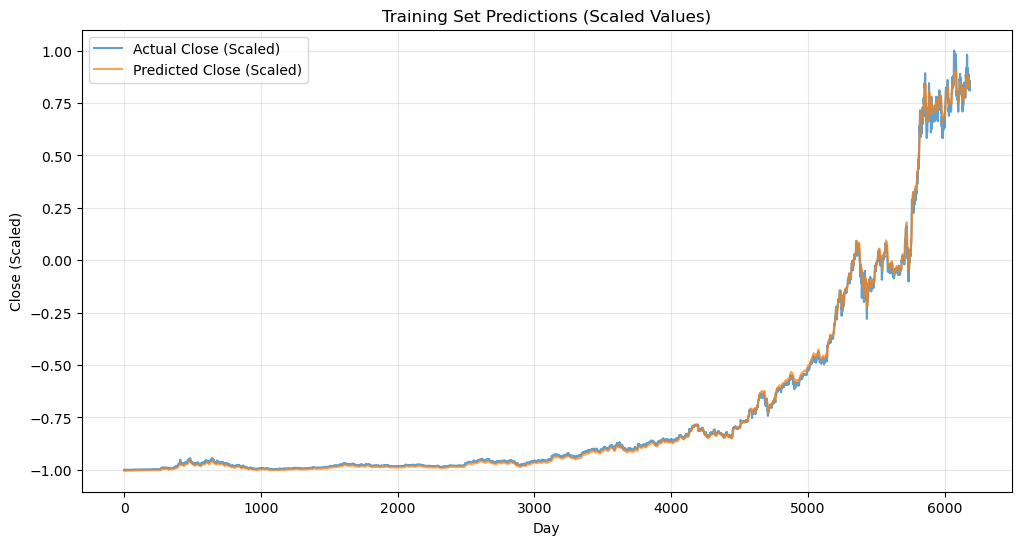

In [82]:
# Generate predictions on training data (scaled values)
with torch.no_grad():
    model.eval()  # Ensure model is in evaluation mode
    predicted = model(X_train.to(device)).cpu().numpy()

plt.figure(figsize=(12, 6))
plt.plot(y_train.numpy(), label='Actual Close (Scaled)', alpha=0.7)
plt.plot(predicted, label='Predicted Close (Scaled)', alpha=0.7)
plt.xlabel('Day')
plt.ylabel('Close (Scaled)')
plt.title('Training Set Predictions (Scaled Values)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [83]:
# Convert training predictions back to original scale
train_predictions = predicted.flatten()

# Create dummy array for inverse transformation
# Need to match the original scaler's feature count (lookback + 1)
dummies = np.zeros((X_train.shape[0], lookback + 1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

# Extract the unscaled predictions
train_predictions = dc(dummies[:, 0])
print(f"Training predictions shape: {train_predictions.shape}")
print(f"Price range: ${train_predictions.min():.2f} - ${train_predictions.max():.2f}")
train_predictions

Training predictions shape: (6183,)
Price range: $-0.33 - $178.25


array([ -0.32797345,  -0.32947414,  -0.33069693, ..., 171.3514657 ,
       170.82652321, 171.05652946])

In [84]:
# Convert training actual values back to original scale
dummies = np.zeros((X_train.shape[0], lookback + 1))
dummies[:, 0] = y_train.detach().numpy().flatten()  # Convert tensor to numpy first
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
print(f"Training actuals shape: {new_y_train.shape}")
print(f"Actual price range: ${new_y_train.min():.2f} - ${new_y_train.max():.2f}")
new_y_train

Training actuals shape: (6183,)
Actual price range: $0.07 - $186.57


array([7.91646265e-02, 7.65634249e-02, 7.52572660e-02, ...,
       1.69091505e+02, 1.73315001e+02, 1.68871003e+02])

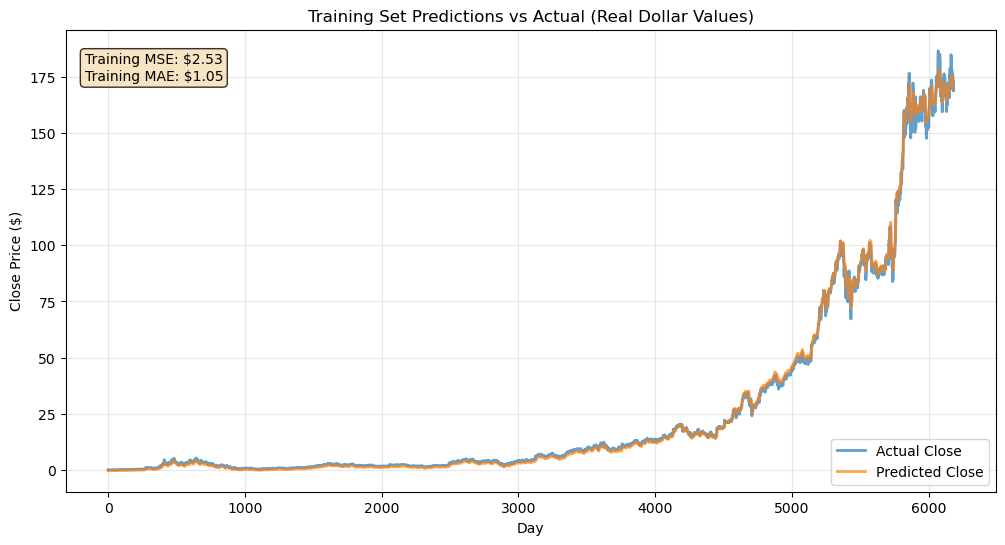

In [85]:
# Plot training results in real dollar values
plt.figure(figsize=(12, 6))
plt.plot(new_y_train, label='Actual Close', alpha=0.7, linewidth=2)
plt.plot(train_predictions, label='Predicted Close', alpha=0.7, linewidth=2)
plt.xlabel('Day')
plt.ylabel('Close Price ($)')
plt.title('Training Set Predictions vs Actual (Real Dollar Values)')
plt.legend()
plt.grid(True, alpha=0.3)

# Calculate and display training metrics
train_mse = np.mean((new_y_train - train_predictions) ** 2)
train_mae = np.mean(np.abs(new_y_train - train_predictions))
plt.text(0.02, 0.95, f'Training MSE: ${train_mse:.2f}\nTraining MAE: ${train_mae:.2f}', 
         transform=plt.gca().transAxes, bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.8),
         verticalalignment='top')

plt.show()

In [86]:
# Generate test predictions and convert to original scale
with torch.no_grad():
    model.eval()
    test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

# Convert test predictions back to original scale
dummies = np.zeros((X_test.shape[0], lookback + 1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
print(f"Test predictions shape: {test_predictions.shape}")
print(f"Test prediction range: ${test_predictions.min():.2f} - ${test_predictions.max():.2f}")
test_predictions

Test predictions shape: (326,)
Test prediction range: $84.52 - $170.45


array([170.45072739, 170.09699732, 169.39667381, 169.4328572 ,
       169.69627888, 169.93492245, 169.75350532, 169.88574418,
       169.7196897 , 169.56711922, 169.01094007, 169.16980235,
       168.8547457 , 168.05072984, 167.1373079 , 166.32534393,
       165.50247492, 165.66758453, 165.70491288, 165.05480146,
       164.76881379, 163.95683871, 162.76853423, 160.86008597,
       157.07917274, 154.42230098, 151.38973344, 148.67397892,
       146.92478201, 146.8920669 , 148.54674237, 150.57748045,
       151.85214705, 149.96415269, 153.21083024, 155.80073773,
       158.36543358, 160.04240825, 160.75142466, 160.01562921,
       160.25805231, 160.08539477, 160.32595034, 159.6657009 ,
       158.65376678, 157.35277691, 155.24884946, 155.08434013,
       155.58228127, 155.87862927, 155.64723349, 155.71256367,
       154.8482533 , 153.80878424, 150.63610753, 147.58207453,
       146.14169805, 147.27425456, 147.80228736, 147.35142354,
       148.48270168, 151.13938446, 154.21681717, 157.32

In [87]:
# Convert test actuals back to original scale
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.detach().cpu().numpy().flatten()
dummies = scaler.inverse_transform(dummies)
test_actuals = dummies[:, 0]

print(f"Test actuals shape: {test_actuals.shape}")
print(f"Test actual range: ${test_actuals.min():.2f} - ${test_actuals.max():.2f}")

Test actuals shape: (326,)
Test actual range: $81.82 - $171.07


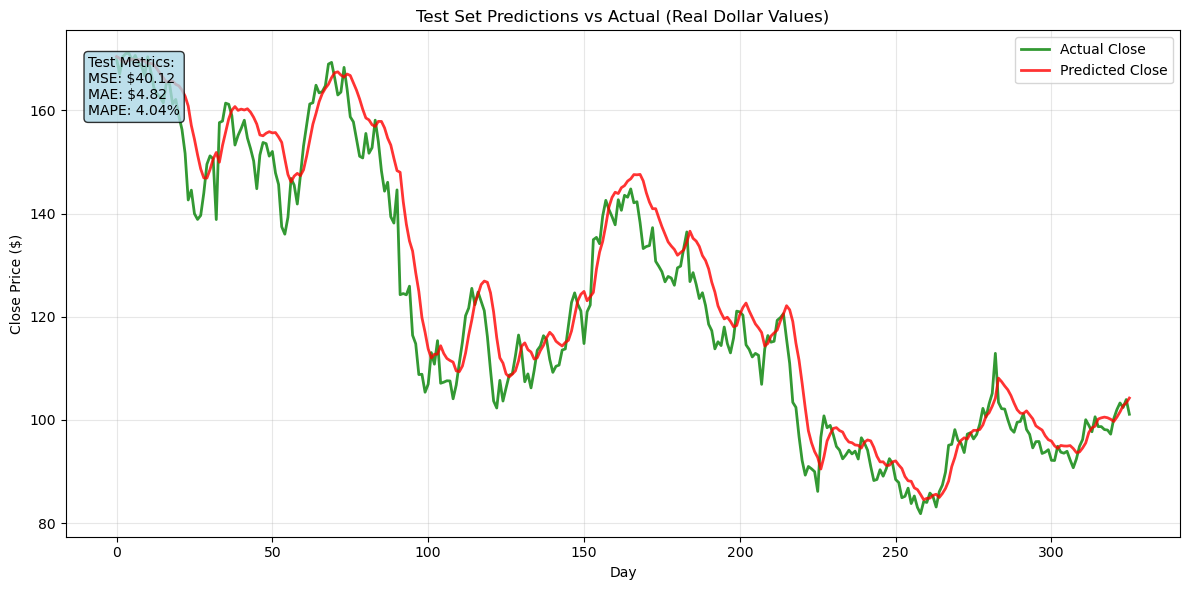


Final Model Performance Summary:
Test Mean Squared Error: $40.12
Test Mean Absolute Error: $4.82
Test Mean Absolute Percentage Error: 4.04%
Model Accuracy: 95.96%


In [88]:
# Plot test results in real dollar values
plt.figure(figsize=(12, 6))
plt.plot(test_actuals, label='Actual Close', alpha=0.8, linewidth=2, color='green')
plt.plot(test_predictions, label='Predicted Close', alpha=0.8, linewidth=2, color='red')
plt.xlabel('Day')
plt.ylabel('Close Price ($)')
plt.title('Test Set Predictions vs Actual (Real Dollar Values)')
plt.legend()
plt.grid(True, alpha=0.3)

# Calculate and display test metrics
test_mse = np.mean((test_actuals - test_predictions) ** 2)
test_mae = np.mean(np.abs(test_actuals - test_predictions))
test_mape = np.mean(np.abs((test_actuals - test_predictions) / test_actuals)) * 100

# Add metrics to plot
metrics_text = f'Test Metrics:\nMSE: ${test_mse:.2f}\nMAE: ${test_mae:.2f}\nMAPE: {test_mape:.2f}%'
plt.text(0.02, 0.95, metrics_text, 
         transform=plt.gca().transAxes, bbox=dict(boxstyle="round", facecolor='lightblue', alpha=0.8),
         verticalalignment='top')

plt.tight_layout()
plt.show()

print(f"\nFinal Model Performance Summary:")
print(f"================================")
print(f"Test Mean Squared Error: ${test_mse:.2f}")
print(f"Test Mean Absolute Error: ${test_mae:.2f}")
print(f"Test Mean Absolute Percentage Error: {test_mape:.2f}%")
print(f"Model Accuracy: {100 - test_mape:.2f}%")